In [38]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
# ================== Dataset ==================
class CarlaDataset(Dataset):
    def __init__(self, images, angles, signals, transform=None):
        self.images = images
        self.angles = angles
        self.signals = signals
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        angle = self.angles[idx]
        signal = self.signals[idx]

        if self.transform:
            img = self.transform(img)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(signal).unsqueeze(0), torch.tensor(angle, dtype=torch.float32)

In [40]:
# ================== Model ==================
class SteeringModel(nn.Module):
    def __init__(self):
        super(SteeringModel, self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        for param in resnet.layer4.parameters():
            param.requires_grad = True

        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])  # (B, 512, 1, 1)

        self.signal_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )

        self.fc_left = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.fc_right = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.fc_straight = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, signal):
        x = self.cnn_backbone(image)
        x = x.view(x.size(0), -1)
        s = self.signal_fc(signal)
        combined = torch.cat([x, s], dim=1)

        preds = torch.zeros(image.size(0), 1, device=image.device)

        left_mask = (signal.squeeze(1) == -1)
        right_mask = (signal.squeeze(1) == 1)
        straight_mask = (signal.squeeze(1) == 0)

        if left_mask.any():
            preds[left_mask] = self.fc_left(combined[left_mask])
        if right_mask.any():
            preds[right_mask] = self.fc_right(combined[right_mask])
        if straight_mask.any():
            preds[straight_mask] = self.fc_straight(combined[straight_mask])

        return preds.squeeze(1)

In [41]:
# ================== Loss ==================
class DirectionalWeightedMSE(nn.Module):
    def __init__(self, left_weight=3.5, right_weight=2.0, straight_weight=0.8):
        super().__init__()
        self.left_weight = left_weight
        self.right_weight = right_weight
        self.straight_weight = straight_weight

    def forward(self, preds, targets, signals):
        weights = torch.ones_like(targets)
        weights[signals.squeeze() == -1] = self.left_weight
        weights[signals.squeeze() == 1] = self.right_weight
        weights[signals.squeeze() == 0] = self.straight_weight
        loss = weights * (preds - targets) ** 2
        return loss.mean()

In [42]:
# ================== Load Data ==================
images = np.load('../output/std_images.npy')         # (N, 3, 224, 224)
angles = np.load('../output/std_angles.npy').astype(np.float32)
signals = np.load('../output/std_turn_signals.npy').astype(np.float32)

train_idx, val_idx = train_test_split(np.arange(len(images)), test_size=0.2, random_state=42)

train_data = (images[train_idx], angles[train_idx], signals[train_idx])
val_data = (images[val_idx], angles[val_idx], signals[val_idx])

In [43]:
# ================== Transforms ==================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [44]:
# ================== Dataloaders ==================
train_dataset = CarlaDataset(*train_data, transform=transform)
val_dataset = CarlaDataset(*val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [45]:
# ================== Training Setup ==================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SteeringModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = DirectionalWeightedMSE()

train_losses = []
val_losses = []
best_val_loss = float('inf')

In [ ]:
# ================== Training Loop ==================
for epoch in range(10):
    model.train()
    total_train_loss = 0
    for images, signals, angles in train_loader:
        images, signals, angles = images.to(device), signals.to(device), angles.to(device)

        optimizer.zero_grad()
        preds = model(images, signals)
        loss = criterion(preds, angles, signals)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, signals, angles in val_loader:
            images, signals, angles = images.to(device), signals.to(device), angles.to(device)
            preds = model(images, signals)
            loss = criterion(preds, angles, signals)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "../models/RDModel_SplitHeads_3.pth")

C:\Users\Pravin\AppData\Local\Temp\ipykernel_27820\3248010433.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(signal).unsqueeze(0), torch.tensor(angle, dtype=torch.float32)


Epoch 1 | Train Loss: 0.0097 | Val Loss: 0.0050
Epoch 2 | Train Loss: 0.0031 | Val Loss: 0.0030
Epoch 3 | Train Loss: 0.0018 | Val Loss: 0.0023
Epoch 4 | Train Loss: 0.0013 | Val Loss: 0.0023
Epoch 5 | Train Loss: 0.0012 | Val Loss: 0.0030
Epoch 6 | Train Loss: 0.0011 | Val Loss: 0.0023
Epoch 7 | Train Loss: 0.0009 | Val Loss: 0.0026
Epoch 8 | Train Loss: 0.0010 | Val Loss: 0.0018
Epoch 9 | Train Loss: 0.0008 | Val Loss: 0.0019
Epoch 10 | Train Loss: 0.0008 | Val Loss: 0.0024


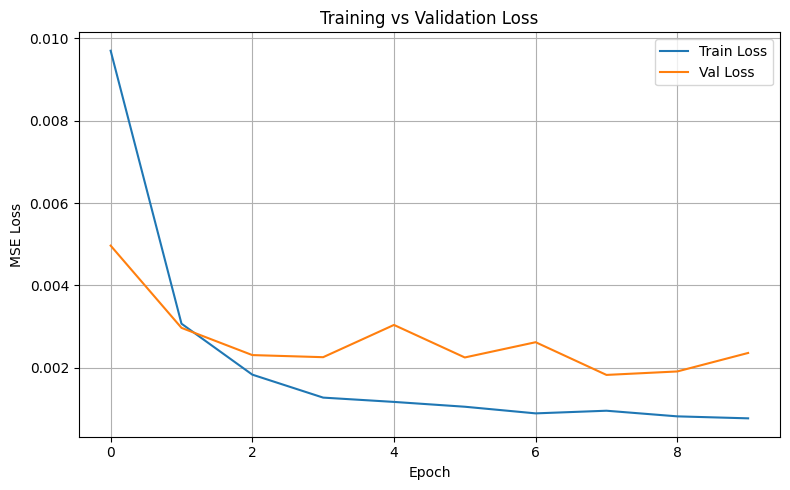

In [47]:
# ================== Plot Loss ==================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curves.png")
plt.show()